In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score
from sklearn.naive_bayes import GaussianNB

In [36]:
### !!! VERY CONSUMING OPERATION !!! ###

# Path to the directory containing the CSV files
path = "TON_IOT_Datasets/Processed_Network_dataset/"

# Define the target number of rows
target_row_count = 5_000_000
rows_per_file = target_row_count // 23

# Use glob to get all file paths matching the pattern
all_files = glob.glob(path + "Network_dataset_*.csv")

# Initialize an empty list to store sampled DataFrames
sampled_dfs = []

# Loop through each file, read it in its entirety, and sample rows
for filename in all_files:
    df = pd.read_csv(filename, low_memory=False)
    sampled_df = df.sample(n=min(len(df), rows_per_file), random_state=42)
    sampled_dfs.append(sampled_df)

# Concatenate all sampled DataFrames into one
combined_df = pd.concat(sampled_dfs, ignore_index=True)

# Adjust the sample size if combined_df has fewer rows than target_row_count
final_sample_size = min(len(combined_df), target_row_count)

# Randomly shuffle and limit rows to final_sample_size
final_df = combined_df.sample(n=final_sample_size, random_state=42).reset_index(drop=True)
df = final_df

df.head()

,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type,uid
0,1556029027,192.168.1.31,53386,192.168.35.151,443,tcp,-,0.000000,0,0,...,0,-,-,-,-,-,-,1,scanning,NaN
1,1556027221,192.168.1.30,53241,192.168.1.180,63606,tcp,-,0.000000,0,0,...,0,-,-,-,-,-,-,1,scanning,NaN
2,1556238678,192.168.1.30,48844,192.168.1.184,80,tcp,http,0.006884,175,171,...,0,-,-,-,-,-,-,1,ddos,NaN
3,1556263694,192.168.1.38,41894,192.168.1.152,80,tcp,-,39.893225,0,0,...,0,-,-,-,-,-,-,1,ddos,NaN
4,1556133212,192.168.1.30,438,192.168.1.184,438,tcp,-,0.000001,0,0,...,0,-,-,-,-,-,-,1,dos,NaN


In [37]:
# Display the distribution of attack types in the final dataset
df['type'].value_counts()

type
scanning      1552228
ddos          1340172
dos            733790
xss            458530
password       373434
backdoor       239504
normal         187326
injection       98449
ransomware      15887
mitm              673
Name: count, dtype: int64

In [38]:
# Check for null values in the features
df.isnull().sum()

ts                              0
src_ip                          0
src_port                        0
dst_ip                          0
dst_port                        0
proto                           0
service                         0
duration                        0
src_bytes                       0
dst_bytes                       0
conn_state                      0
missed_bytes                    0
src_pkts                        0
src_ip_bytes                    0
dst_pkts                        0
dst_ip_bytes                    0
dns_query                       0
dns_qclass                      0
dns_qtype                       0
dns_rcode                       0
dns_AA                          0
dns_RD                          0
dns_RA                          0
dns_rejected                    0
ssl_version                     0
ssl_cipher                      0
ssl_resumed                     0
ssl_established                 0
ssl_subject                     0
ssl_issuer    

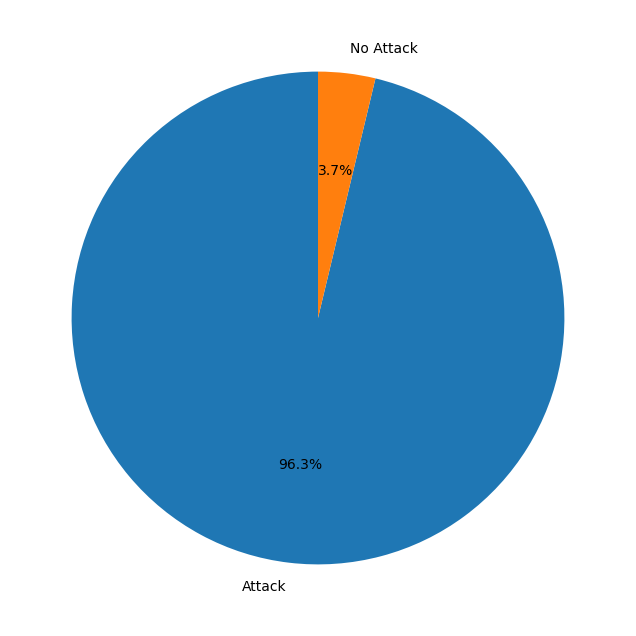

In [39]:
# Create pie chart which shows the percentage of attacks
attack_counts = df['label'].value_counts()
attack_counts.plot(kind='pie', 
                   labels=attack_counts.index.map({0: 'No Attack', 1: 'Attack'}), 
                   autopct='%1.1f%%', 
                   startangle=90, 
                   figsize=(8, 8))

# Show the plot
plt.ylabel('')  # Remove the y-axis label
plt.show()

In [40]:
# Show the types of each column
df.dtypes

ts                          int64
src_ip                     object
src_port                    int64
dst_ip                     object
dst_port                    int64
proto                      object
service                    object
duration                  float64
src_bytes                  object
dst_bytes                   int64
conn_state                 object
missed_bytes                int64
src_pkts                    int64
src_ip_bytes                int64
dst_pkts                    int64
dst_ip_bytes                int64
dns_query                  object
dns_qclass                  int64
dns_qtype                   int64
dns_rcode                   int64
dns_AA                     object
dns_RD                     object
dns_RA                     object
dns_rejected               object
ssl_version                object
ssl_cipher                 object
ssl_resumed                object
ssl_established            object
ssl_subject                object
ssl_issuer    

In [41]:
label_encoder = LabelEncoder()
label_mappings = {}

# Apply label encoding to each non-numeric column and store mappings
for column in df.select_dtypes(include=['object']).columns:
    # Convert the column to string type to avoid mixed types
    df[column] = df[column].astype(str)
    
    df.loc[:, column] = label_encoder.fit_transform(df[column])

    # Convert the encoded column to integer type explicitly
    df[column] = df[column].astype(int)
    
    # Store the mapping of label to encoded value for the column
    label_mappings[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

for column, mapping in label_mappings.items():
    print(f"{column}: {dict(list(mapping.items())[:5])}")

src_ip: {'0': 0, '0.0.0.0': 1, '0.105.134.68': 2, '0.11.129.89': 3, '0.130.71.43': 4}
dst_ip: {'101.119.11.10': 0, '101.119.11.11': 1, '101.119.11.16': 2, '101.119.11.17': 3, '101.119.11.19': 4}
proto: {'icmp': 0, 'tcp': 1, 'udp': 2}
service: {'-': 0, 'dce_rpc': 1, 'dce_rpc;gssapi;smb;ntlm': 2, 'dce_rpc;ntlm': 3, 'dhcp': 4}
src_bytes: {'0': 0, '0.0.0.0': 1, '1': 2, '10': 3, '100': 4}
conn_state: {'OTH': 0, 'REJ': 1, 'RSTO': 2, 'RSTOS0': 3, 'RSTR': 4}
dns_query: {'(empty)': 0, '*\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00\\x00': 1, '-': 2, '../nessus': 3, '0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.ip6.arpa': 4}
dns_AA: {'-': 0, 'F': 1, 'T': 2}
dns_RD: {'-': 0, 'F': 1, 'T': 2}
dns_RA: {'-': 0, 'F': 1, 'T': 2}
dns_rejected: {'-': 0, 'F': 1, 'T': 2}
ssl_version: {'-': 0, 'TLSv10': 1, 'TLSv11': 2, 'TLSv12': 3, 'TLSv13': 4}
ssl_cipher: {'-': 0, 'TLS_AES_128_GCM_SHA256': 1, 'TLS_DHE_RSA_WITH_AES_128_CBC_SHA': 2, 'TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA25

In [42]:
# Print the mapping specifically for the 'type' column
print("Type column mappings:", label_mappings.get('type', 'No mapping found for type'))

Type column mappings: {'backdoor': 0, 'ddos': 1, 'dos': 2, 'injection': 3, 'mitm': 4, 'normal': 5, 'password': 6, 'ransomware': 7, 'scanning': 8, 'xss': 9}


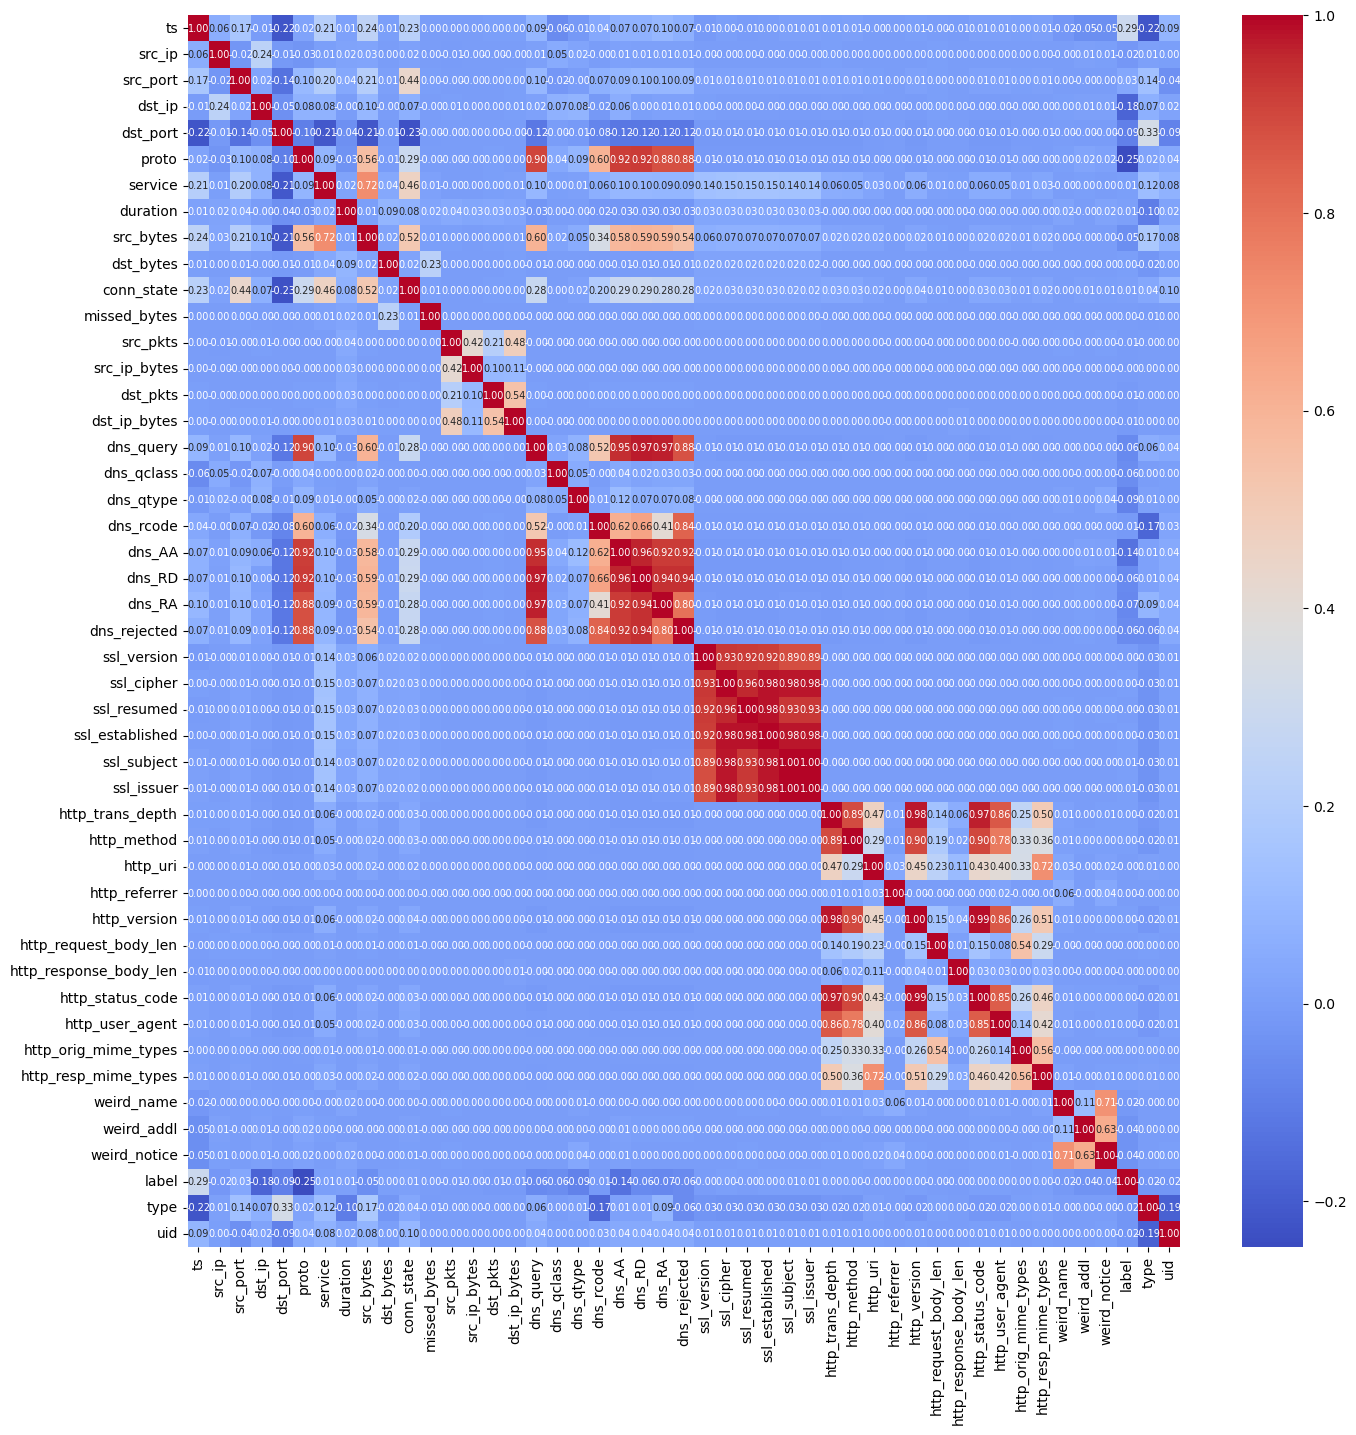

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove columns with only one unique value and create a copy
df = df.loc[:, df.nunique() > 1].copy()

# Calculate the correlation matrix
corr = df.corr()

# Visualize the correlation matrix with improved readability
plt.figure(figsize=(16, 16))  # Set a large figure size
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 7})

# Show the plot
plt.show()

In [44]:
# Identify and drop highly correlated features
# Set a threshold for correlation
threshold = 0.80
to_drop = set()

for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > threshold:
            colname = corr.columns[i]
            to_drop.add(colname)

# Drop the correlated features
df = df.drop(columns=to_drop)

df.head()

,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_request_body_len,http_response_body_len,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type,uid
0,1556029027,2084,53386,1197,443,1,0,0.000000,0,0,...,0,0,0,0,0,0,0,1,8,217388
1,1556027221,2083,53241,1122,63606,1,0,0.000000,0,0,...,0,0,0,0,0,0,0,1,8,217388
2,1556238678,2083,48844,1123,80,1,13,0.006884,3829,171,...,0,0,0,0,0,0,0,1,1,217388
3,1556263694,2091,41894,1120,80,1,0,39.893225,0,0,...,0,0,0,0,0,0,0,1,1,217388
4,1556133212,2083,438,1123,438,1,0,0.000001,0,0,...,0,0,0,0,0,0,0,1,2,217388


In [45]:
df.head()

,ts,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,...,http_request_body_len,http_response_body_len,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type,uid
0,1556029027,2084,53386,1197,443,1,0,0.000000,0,0,...,0,0,0,0,0,0,0,1,8,217388
1,1556027221,2083,53241,1122,63606,1,0,0.000000,0,0,...,0,0,0,0,0,0,0,1,8,217388
2,1556238678,2083,48844,1123,80,1,13,0.006884,3829,171,...,0,0,0,0,0,0,0,1,1,217388
3,1556263694,2091,41894,1120,80,1,0,39.893225,0,0,...,0,0,0,0,0,0,0,1,1,217388
4,1556133212,2083,438,1123,438,1,0,0.000001,0,0,...,0,0,0,0,0,0,0,1,2,217388


In [46]:
# Remove the attack type column
features = df.drop(['type', 'label'], axis=1)  

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform PCA without specifying n_components
pca = PCA()
pca.fit(scaled_features)

# Calculate cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

print(f'Explained variance by each component: {pca.explained_variance_ratio_}')

# Set the variance threshold 
threshold = 0.90
n_components = np.argmax(explained_variance >= threshold) + 1

print(f"Number of components to retain {threshold*100}% variance: {n_components}")

# Perform PCA again with the chosen number of components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_features)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, 
                      columns=[f'PC{i+1}' for i in range(n_components)])
pca_df['type'] = df['type'].values
pca_df['label'] = df['label'].values

Explained variance by each component: [0.09527186 0.08577852 0.06493574 0.06353201 0.04758818 0.04174183
 0.04012568 0.03615119 0.03488282 0.03458212 0.03408034 0.03253943
 0.0321506  0.03178747 0.03105691 0.03077693 0.02870316 0.02820009
 0.02726556 0.02581869 0.0245788  0.02261861 0.02010001 0.01859417
 0.01479001 0.01428982 0.01330012 0.01065463 0.00681192 0.00385409
 0.0034387 ]
Number of components to retain 90.0% variance: 23


In [47]:
df = pca_df;
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,type,label
0,-0.410050,0.055690,0.016365,-0.007907,-0.191401,-0.012621,-0.075048,0.045918,0.013115,-0.068783,...,0.106955,0.177996,0.244379,0.860253,-0.541419,0.113575,-0.478835,-0.001186,8,1
1,-1.454878,0.273129,0.042412,-0.003111,0.781393,-0.168427,0.234892,-0.196650,-0.056244,1.355222,...,0.029938,1.796380,-1.969589,1.070314,2.031113,0.010738,0.763628,-0.021771,8,1
2,1.540593,-0.310775,-0.074375,-0.006319,-1.158003,-0.178954,-0.285642,-0.005575,-0.033386,0.339717,...,0.223763,0.311187,-0.275141,-0.231494,-0.085343,-0.056561,-0.459521,-0.002472,1,1
3,0.014022,-0.032868,-0.049147,0.031180,-0.612528,-0.149166,-0.081367,0.137192,0.056857,-0.506626,...,-0.010662,-0.104819,0.294307,0.390774,0.060583,-0.030866,-0.063049,-0.005617,1,1
4,-1.588095,0.296398,-0.003116,0.004982,0.480007,0.263751,0.098007,-0.015724,0.007718,-0.553379,...,-0.075836,-0.520442,0.337305,-0.955294,-0.449285,-0.079153,-0.061786,0.008016,2,1


In [33]:
# Bosch analysis. Work above this cells
df = df.dropna()

# Filter the DataFrame to include only rows where 'type' column is 0 (backdoor) or 5 (normal)
filtered_df = df[(df['type'] == 0) | (df['type'] == 5)]

X_df = filtered_df.drop(columns=['label', 'type'])
Y_df = filtered_df['label']

# X_df.head()
Y_df.head()

19    1
27    1
43    0
67    0
76    0
Name: label, dtype: int64

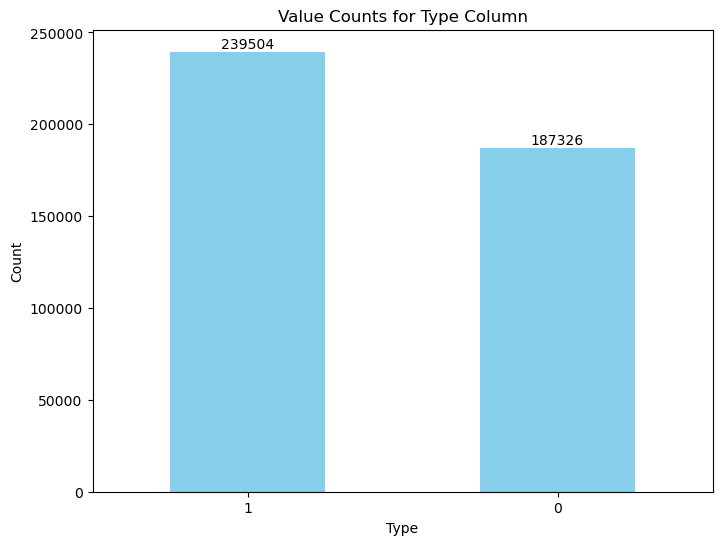

In [15]:
# Get the value counts for the 'type' column
type_counts = Y_df.value_counts()

# Plot a bar chart
plt.figure(figsize=(8, 6))
ax = type_counts.plot(kind='bar', color='skyblue')
plt.title('Value Counts for Type Column')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

plt.show()

In [16]:
# from sklearn.model_selection import train_test_split

# # Split data into 80% train and 20% test sets
# X_train, X_test, Y_train, Y_test = train_test_split(X_df, Y_df, test_size=0.2, random_state=42)

# # Display the shapes of the resulting datasets
# print(f'X_train: {X_train.shape}, X_test: {X_test.shape}')
# print(f'Y_train: {Y_train.shape}, Y_test: {Y_test.shape}')

In [17]:
filtered_df.dtypes

PC1      float64
PC2      float64
PC3      float64
PC4      float64
PC5      float64
PC6      float64
PC7      float64
PC8      float64
PC9      float64
PC10     float64
PC11     float64
PC12     float64
PC13     float64
PC14     float64
PC15     float64
PC16     float64
PC17     float64
PC18     float64
PC19     float64
PC20     float64
PC21     float64
PC22     float64
PC23     float64
type       int64
label      int64
dtype: object

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Initialize models
rf = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42)

In [19]:
# # Create pie chart which shows the percentage of attacks
# attack_counts = Y_test.value_counts()
# attack_counts.plot(kind='pie', 
#                    labels=attack_counts.index.map({0: 'No Attack', 1: 'Attack'}), 
#                    autopct='%1.1f%%', 
#                    startangle=90, 
#                    figsize=(8, 8))

# # Show the plot
# plt.ylabel('')  # Remove the y-axis label
# plt.show()

In [20]:
# # Train Random Forest
# rf.fit(X_train, Y_train)
# y_pred_rf = rf.predict(X_test)

# print('Training completed')

In [21]:
# # Train SVM
# svm.fit(X_train, Y_train)
# y_pred_svm = svm.predict(X_test)

# print('Training completed')

In [22]:
# # Compute the confusion matrix
# # Ensure both classes are considered by specifying labels=[0, 1]
# tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_rf, labels=[0, 1]).ravel()

# # Calculate metrics
# accuracy = accuracy_score(Y_test, y_pred_rf)
# precision = precision_score(Y_test, y_pred_rf, zero_division=1)
# sensitivity = recall_score(Y_test, y_pred_rf, zero_division=1)  # Sensitivity (Recall)
# specificity = tn / (tn + fp) if (tn + fp) > 0 else 0            # Specificity formula

# # Store results in a dictionary
# rf_results = {
#     "TP": tp,
#     "TN": tn,
#     "FP": fp,
#     "FN": fn,
#     "Accuracy": accuracy,
#     "Precision": precision,
#     "Sensitivity (Recall)": sensitivity,
#     "Specificity": specificity
# }

# print("Random Forest Results:", rf_results)

In [23]:
# # Compute the confusion matrix
# # Ensure both classes are considered by specifying labels=[0, 1]
# tn, fp, fn, tp = confusion_matrix(Y_test, y_pred_svm, labels=[0, 1]).ravel()

# # Calculate metrics
# accuracy = accuracy_score(Y_test, y_pred_svm)
# precision = precision_score(Y_test, y_pred_svm, zero_division=1)
# sensitivity = recall_score(Y_test, y_pred_svm, zero_division=1)  # Sensitivity (Recall)
# specificity = tn / (tn + fp) if (tn + fp) > 0 else 0            # Specificity formula

# # Store results in a dictionary
# svm_results = {
#     "TP": tp,
#     "TN": tn,
#     "FP": fp,
#     "FN": fn,
#     "Accuracy": accuracy,
#     "Precision": precision,
#     "Sensitivity (Recall)": sensitivity,
#     "Specificity": specificity
# }

# print("SVM Results:", svm_results)

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Define a function to calculate all metrics
def calculate_metrics(y_true, y_pred):
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate

    return {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity (Recall)': recall,
        'Specificity': specificity
    }

# Cross-validation setup
kf = StratifiedKFold(n_splits=5)
rf_metrics = []
svm_metrics = []

# Cross-validation for Random Forest
print("Random Forest Cross-Validation Results:")
for train_index, test_index in kf.split(X_df, Y_df):
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = Y_df.iloc[train_index], Y_df.iloc[test_index]
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    rf_metrics.append(calculate_metrics(y_test, y_pred))

# Display results for Random Forest
rf_results_df = pd.DataFrame(rf_metrics)
print(rf_results_df)
print("Mean Results for Random Forest:")
print(rf_results_df.mean())

# Cross-validation for SVM
print("\nSVM Cross-Validation Results:")
for train_index, test_index in kf.split(X_df, Y_df):
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = Y_df.iloc[train_index], Y_df.iloc[test_index]
    
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    svm_metrics.append(calculate_metrics(y_test, y_pred))

# Display results for SVM
svm_results_df = pd.DataFrame(svm_metrics)
print(svm_results_df)
print("Mean Results for SVM:")
print(svm_results_df.mean())

Random Forest Cross-Validation Results:
      TP     TN  FP  FN  Accuracy  Precision  Sensitivity (Recall)  \
0  47892  37465   0   9  0.999895   1.000000              0.999812   
1  47895  37464   1   6  0.999918   0.999979              0.999875   
2  47897  37465   0   4  0.999953   1.000000              0.999916   
3  47895  37465   0   6  0.999930   1.000000              0.999875   
4  47897  37466   0   3  0.999965   1.000000              0.999937   

   Specificity  
0     1.000000  
1     0.999973  
2     1.000000  
3     1.000000  
4     1.000000  
Mean Results for Random Forest:
TP                      47895.200000
TN                      37465.000000
FP                          0.200000
FN                          5.600000
Accuracy                    0.999932
Precision                   0.999996
Sensitivity (Recall)        0.999883
Specificity                 0.999995
dtype: float64

SVM Cross-Validation Results:


In [53]:
df = df.dropna()

filtered_df = df[(df['type'] == 3) | (df['type'] == 5)]

# Prepare features (X) and target (y)
X = filtered_df.drop(columns=['label', 'type'])  # Drop non-feature columns
y = filtered_df['label']  # Target variable is 'label'

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize StratifiedKFold with 5 splits
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

# Initialize lists to store metrics
precision_list = []
accuracy_list = []
sensitivity_list = []
tp_list, tn_list, fp_list, fn_list = [], [], [], []

# Perform cross-validation
for run_index, (train_idx, test_idx) in enumerate(kf.split(X_scaled, y), start=1):  # Use enumerate to track the run index
    # Split the data into training and testing sets for this fold
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Initialize and train Logistic Regression model
    model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=50)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Append confusion matrix components
    tp_list.append(tp)
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)  # Sensitivity = Recall
    
    # Append metrics to lists
    precision_list.append(precision)
    accuracy_list.append(accuracy)
    sensitivity_list.append(sensitivity)
    
    # Print results for the current run
    print(f"=== RUN NUMBER {run_index} ===")  # Display the current run index
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"Precision: {precision:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Sensitivity (Recall): {sensitivity:.2f}")
    print()


# Calculate average metrics
avg_precision = sum(precision_list) / len(precision_list)
avg_accuracy = sum(accuracy_list) / len(accuracy_list)
avg_sensitivity = sum(sensitivity_list) / len(sensitivity_list)
avg_tp = sum(tp_list) / len(tp_list)
avg_tn = sum(tn_list) / len(tn_list)
avg_fp = sum(fp_list) / len(fp_list)
avg_fn = sum(fn_list) / len(fn_list)

print("=== Cross-Validation Results (5-Fold) ===")
print(f"Average True Positives (TP): {avg_tp:.2f}")
print(f"Average True Negatives (TN): {avg_tn:.2f}")
print(f"Average False Positives (FP): {avg_fp:.2f}")
print(f"Average False Negatives (FN): {avg_fn:.2f}")
print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Accuracy: {avg_accuracy:.2f}")
print(f"Average Sensitivity (Recall): {avg_sensitivity:.2f}")

=== RUN NUMBER 1 ===
True Positives (TP): 18476
True Negatives (TN): 36524
False Positives (FP): 941
False Negatives (FN): 1214
Precision: 0.95
Accuracy: 0.96
Sensitivity (Recall): 0.94

=== RUN NUMBER 2 ===
True Positives (TP): 18429
True Negatives (TN): 36614
False Positives (FP): 851
False Negatives (FN): 1261
Precision: 0.96
Accuracy: 0.96
Sensitivity (Recall): 0.94

=== RUN NUMBER 3 ===
True Positives (TP): 18401
True Negatives (TN): 36597
False Positives (FP): 868
False Negatives (FN): 1289
Precision: 0.95
Accuracy: 0.96
Sensitivity (Recall): 0.93

=== RUN NUMBER 4 ===
True Positives (TP): 18486
True Negatives (TN): 36553
False Positives (FP): 912
False Negatives (FN): 1204
Precision: 0.95
Accuracy: 0.96
Sensitivity (Recall): 0.94

=== RUN NUMBER 5 ===
True Positives (TP): 18483
True Negatives (TN): 36588
False Positives (FP): 878
False Negatives (FN): 1206
Precision: 0.95
Accuracy: 0.96
Sensitivity (Recall): 0.94

=== Cross-Validation Results (5-Fold) ===
Average True Positives 

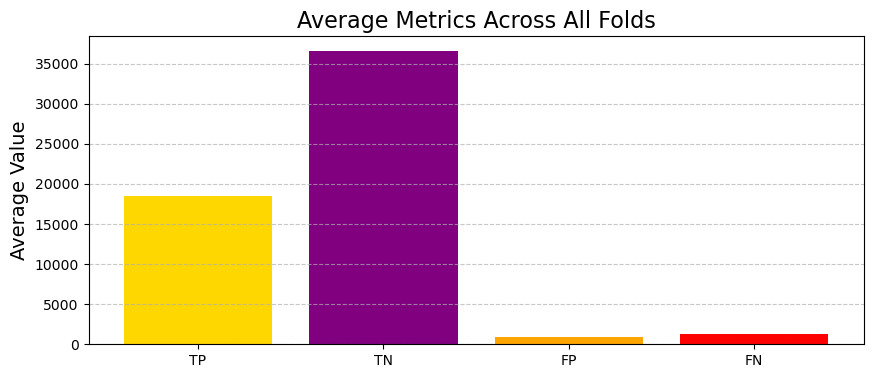

In [50]:

# Number of folds
folds = np.arange(1, 6)  # For 5 folds

# Create a dictionary of results for easier visualization
results = {
    "TP": tp_list,
    "TN": tn_list,
    "FP": fp_list,
    "FN": fn_list,
}

# Bar plot for average metrics
avg_metrics = [avg_tp, avg_tn, avg_fp, avg_fn]
metric_names = ["TP", "TN", "FP", "FN"]

plt.figure(figsize=(10, 4))
plt.bar(metric_names, avg_metrics, color=['gold', 'purple', 'orange', 'red'])
plt.title("Average Metrics Across All Folds", fontsize=16)
plt.ylabel("Average Value", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [54]:
from sklearn.tree import DecisionTreeClassifier

df = df.dropna()

filtered_df = df[(df['type'] == 3) | (df['type'] == 5)]

# Prepare features (X) and target (y)
X = filtered_df.drop(columns=['label', 'type'])  # Drop non-feature columns
y = filtered_df['label']  # Target variable is 'label'

model = DecisionTreeClassifier(random_state=50)

# Initialize Stratified K-Fold cross-validator
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)

# Initialize lists to store metrics
tp_list, tn_list, fp_list, fn_list = [], [], [], []
precision_list, accuracy_list, sensitivity_list = [], [], []

# Perform cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
    print(f"=== Fold {fold} ===")
    
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train the Decision Tree model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Compute confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Compute metrics
    precision = precision_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)  # Sensitivity is Recall
    
    # Store metrics for this fold
    tp_list.append(tp)
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)
    precision_list.append(precision)
    accuracy_list.append(accuracy)
    sensitivity_list.append(sensitivity)
    
    # Print results for this fold
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"Precision: {precision:.5f}")
    print(f"Accuracy: {accuracy:.5f}")
    print(f"Sensitivity (Recall): {sensitivity:.5f}")
    print()


avg_tp = sum(tp_list) / len(tp_list)
avg_tn = sum(tn_list) / len(tn_list)
avg_fp = sum(fp_list) / len(fp_list)
avg_fn = sum(fn_list) / len(fn_list)

print("=== Cross-Validation Results (5-Fold) ===")
print(f"Average True Positives (TP): {avg_tp:.2f}")
print(f"Average True Negatives (TN): {avg_tn:.2f}")
print(f"Average False Positives (FP): {avg_fp:.2f}")
print(f"Average False Negatives (FN): {avg_fn:.2f}")
print(f"Average Precision: {np.mean(precision_list):.5f}")
print(f"Average Accuracy: {np.mean(accuracy_list):.5f}")
print(f"Average Sensitivity (Recall): {np.mean(sensitivity_list):.5f}")

=== Fold 1 ===
True Positives (TP): 19670
True Negatives (TN): 37434
False Positives (FP): 31
False Negatives (FN): 20
Precision: 0.99843
Accuracy: 0.99911
Sensitivity (Recall): 0.99898

=== Fold 2 ===
True Positives (TP): 19669
True Negatives (TN): 37432
False Positives (FP): 33
False Negatives (FN): 21
Precision: 0.99833
Accuracy: 0.99906
Sensitivity (Recall): 0.99893

=== Fold 3 ===
True Positives (TP): 19655
True Negatives (TN): 37438
False Positives (FP): 27
False Negatives (FN): 35
Precision: 0.99863
Accuracy: 0.99892
Sensitivity (Recall): 0.99822

=== Fold 4 ===
True Positives (TP): 19664
True Negatives (TN): 37438
False Positives (FP): 27
False Negatives (FN): 26
Precision: 0.99863
Accuracy: 0.99907
Sensitivity (Recall): 0.99868

=== Fold 5 ===
True Positives (TP): 19662
True Negatives (TN): 37431
False Positives (FP): 35
False Negatives (FN): 27
Precision: 0.99822
Accuracy: 0.99892
Sensitivity (Recall): 0.99863

=== Cross-Validation Results (5-Fold) ===
Average True Positives 